In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier

# Data Cleaning

In [5]:
# chunk_size = 100000

# csv_chunks = pd.read_csv('US_Accidents_March23.csv', chunksize=chunk_size)

# all_chunks = [] 
# for i, chunk in enumerate(csv_chunks):

#     cols_to_keep = ['Severity', 'Temperature(F)', 'Wind_Chill(F)', 
#                     'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 
#                     'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition']

#     df = chunk[cols_to_keep]
#     df = df.fillna(0)

#     all_chunks.append(df)

#     if i == 5:
#         break
# df = pd.concat(all_chunks)

In [6]:
#df = pd.read_csv('cleaned_US_Accidents.csv/cleaned_US_Accidents.csv', index_col=0)
df = pd.read_csv('cleaned_US_Accidents.csv', index_col=0)
cols_to_keep = ['Severity', 'Temperature(F)', 'Wind_Chill(F)', 
                'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 
                'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition']

df = df[cols_to_keep]
df = df.fillna(0)
data = pd.get_dummies(df, drop_first=True, dtype=np.int64)
X = data.drop(columns=['Severity'])
y = data['Severity']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# Random Forest

In [7]:
# Initialize and fit the forest
rf = RandomForestClassifier(oob_score=True)
rf.fit(X_train, y_train)

# Print the oob_score
print(rf.oob_score_)

# Extract the feature importances of the forest
feature_importances = rf.feature_importances_
feature_names = X.columns

features = sorted(zip(feature_importances, feature_names))


print(f'Best Features {features[-3:]}')
print(f'Worst Features {features[:3]}')

0.7433222436344364
Best Features [(np.float64(0.1628062673364735), 'Temperature(F)'), (np.float64(0.22005015341707818), 'Humidity(%)'), (np.float64(0.27563329922458585), 'Pressure(in)')]
Worst Features [(np.float64(0.0007951918521700089), 'Wind_Direction_Variable'), (np.float64(0.0013916485915314236), 'Wind_Direction_VAR'), (np.float64(0.0014887220238105712), 'Wind_Direction_East')]


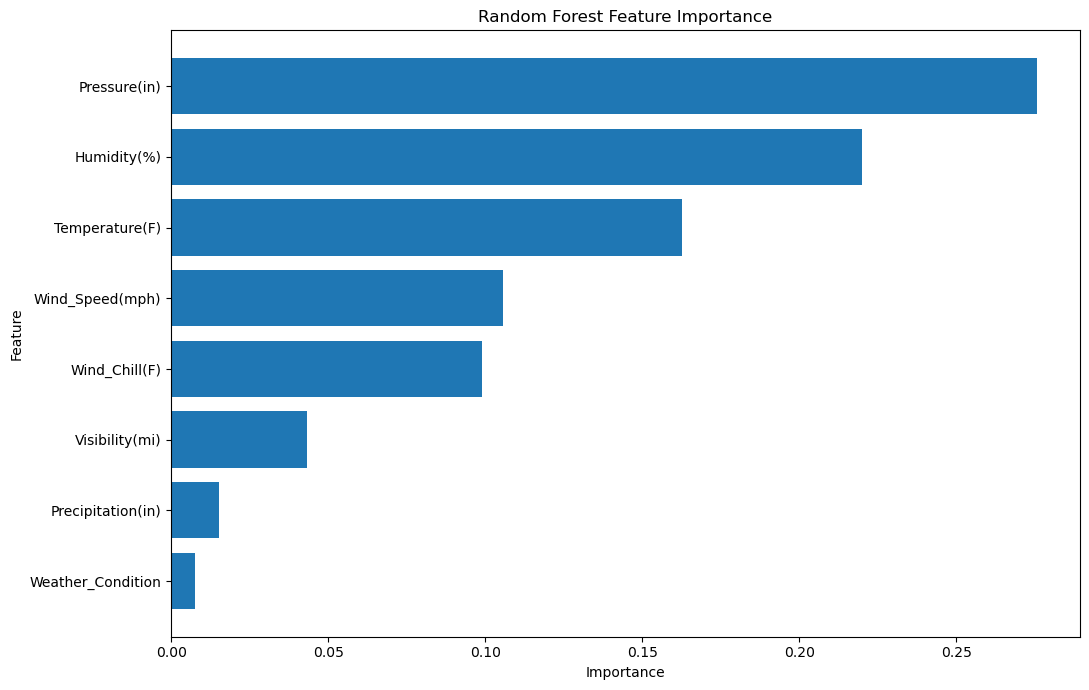

In [14]:
importances = rf.feature_importances_
k = len(importances) // 4
indices = np.argsort(importances)[-k:]

plt.figure(figsize=(11, 7))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('figures/rf_feature_importance')

In [9]:
# # Decide what values of max_depth and max_features to search over
# max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# max_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# best_oob_score = 0
# best_params = None



# # Perform a grid search to find the best parameters
# for max_depth in max_depths:
#   for mf in max_features:
#     # Initialize and fit the forest
#     rf = RandomForestClassifier(oob_score=True, max_depth=max_depth, max_features=mf)
#     rf.fit(X_train, y_train)
      
      
#     # Compare the oob_score to your best oob_score and store the parameters if better
#     if best_oob_score < rf.oob_score_:
#       best_oob_score = rf.oob_score_
#       best_params = max_depth, mf

# # Print the best oob score and the hyperparameters you used to get it
# print(best_oob_score)
# print(best_params)

# Boosting

In [10]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.7628015551608767


In [11]:
# Extract the feature importances of the forest
feature_importances = gb.feature_importances_
feature_names = X.columns

features = sorted(zip(feature_importances, feature_names))


print(f'Best Features {features[-3:]}')
print(f'Worst Features {features[:3]}')

Best Features [(np.float64(0.04947385247722664), 'Wind_Speed(mph)'), (np.float64(0.2862598199384427), 'Pressure(in)'), (np.float64(0.515888545823472), 'Wind_Chill(F)')]
Worst Features [(np.float64(0.0), 'Wind_Direction_ENE'), (np.float64(3.1607864413076035e-06), 'Wind_Direction_ESE'), (np.float64(2.4272454359024845e-05), 'Wind_Direction_NW')]


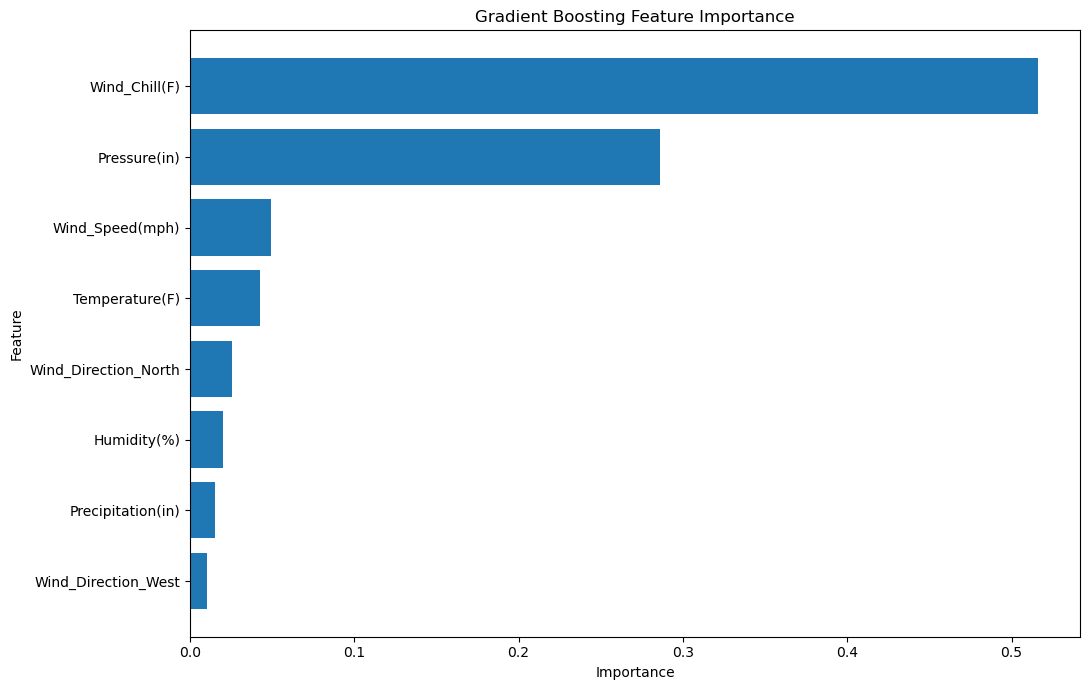

In [13]:
importances = gb.feature_importances_
k = len(importances) // 4
indices = np.argsort(importances)[-k:]

plt.figure(figsize=(11, 7))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("figures/boosting_feature_importance")